In [37]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from quick_pp.objects import Project

# Load well from saved file
project = "MOCK_carbonate"
project_path = rf"data\04_project\{project}.qppp"
project = Project().load(project_path)
project.get_well_names()

['HW-10',
 'HW-24',
 'HW-25',
 'HW-26',
 'HW-27',
 'HW-28',
 'HW-29',
 'HW-3',
 'HW-30',
 'HW-31',
 'HW-32',
 'HW-4',
 'HW-5',
 'HW-6',
 'HW-7',
 'HW-8',
 'HW-9']

In [39]:
# Load data
well_name = 'HW-6'
well = project.get_well(well_name)
well_data = well.data.copy()
well_data['CPORE'] = well_data['CORE_POR'] / 100
well_data['CPERM'] = well_data['CORE_PERM']
# well_data.dropna(subset=['NPHI', 'RHOB', 'RT', 'GR'], inplace=True)

# quick_pp - Lithology Estimation

Lithology refers to the physical characteristics of a rock or rock formation, including its mineral composition, grain size, texture, and color. It’s a fundamental concept in petrophysics and geology, as it helps in understanding the reservoir properties and behavior of subsurface formations.

Evaluating carbonate reservoirs presents unique challenges compared to siliciclastic reservoirs (like sandstones). Here are some key difficulties:

- Heterogeneity: 
    - Carbonate rocks are highly heterogeneous due to their complex depositional environments and diagenetic processes. This variability can make it difficult to predict reservoir quality and performance.

- Porosity Types: 
    - Carbonates exhibit various porosity types, including interparticle, intraparticle, vuggy, and fracture porosity. Each type affects fluid flow differently, complicating the interpretation of petrophysical data.

- Diagenesis: 
    - Post-depositional changes, such as dissolution, recrystallization, and cementation, can significantly alter the original rock properties. These diagenetic processes can enhance or reduce porosity and permeability, adding another layer of complexity to reservoir evaluation.

- Log Interpretation: 
    - Standard logging tools and techniques often struggle to accurately characterize carbonate reservoirs. For instance, the presence of vugs and fractures can lead to misleading porosity readings on conventional logs.

- Fluid Distribution: 
    - Carbonates can have complex fluid distributions due to their pore structure. This can make it challenging to differentiate between hydrocarbons and water, impacting reserve estimates and production strategies.

Addressing these challenges requires a combination of advanced logging techniques, detailed core analysis, and sophisticated modeling approaches. Continuous advancements in technology and methodologies are helping petrophysicists better understand and manage carbonate reservoirs.

In [40]:
import matplotlib.pyplot as plt

from quick_pp.lithology.carbonate import Carbonate
from quick_pp.porosity import neu_den_xplot_poro, density_porosity, rho_matrix
from quick_pp.qaqc import badhole_flagging, mask_outside_threshold, neu_den_xplot_hc_correction
from quick_pp.plotter import plotly_log, neutron_density_xplot
from quick_pp.rock_type import estimate_vsh_gr

In [41]:
carbonate_type =  'limestone'  # 'dolostone'  #
model = 'single'  # 'double'  #
method = 'neu_den'  # 'pef_den'  #

# Clean up data
well_data = badhole_flagging(well_data)
# well_data = mask_outside_threshold(well_data, fill=True)

# Initialize lithology model
args = {
    'litho_model': 'carb',
    'dry_calc_point': (.0, 2.71),
    # 'dry_dolo_point': (.0, 2.81),
    'dry_clay_point': (.3, 2.7),
    'hc_corr_angle': 50,
    'hc_buffer': 0.01,
}
vsh_gr = estimate_vsh_gr(well_data['GR'], min_gr=0, max_gr=150)
carb_model = Carbonate(**args)
vclw, vcalc, vdolo = carb_model.estimate_lithology(
    well_data['NPHI'], well_data['RHOB'], gr=well_data['GR'], vsh_gr=vsh_gr,  # pef=well_data['PEF'],
    model=model, method=method, normalize= True, carbonate_type=carbonate_type
)
args.update(carb_model.__dict__)
well.update_config(args)


# Choose to skip HC correction or not
skip_hc_correction = False
if skip_hc_correction is True:
    nphihc, rhobhc = well_data['NPHI'], well_data['RHOB']
else:
    # Implement hydrocarbon correction
    nphihc, rhobhc, hc_flag = neu_den_xplot_hc_correction(
        well_data['NPHI'], well_data['RHOB'], gr=well_data['GR'], vsh_gr=vsh_gr,
        dry_min1_point=args['dry_calc_point'],
        dry_clay_point=args['dry_clay_point'],
        corr_angle=args['hc_corr_angle'], buffer=args['hc_buffer']
    )

    # Estimate lithology
    carb_model = Carbonate(**args)
    vclw, vcalc, vdolo = carb_model.estimate_lithology(
        nphihc, rhobhc,  gr=well_data['GR'], vsh_gr=vsh_gr,  # pef=well_data['PEF'], 
        model=model, method=method, normalize= True, carbonate_type=carbonate_type
    )

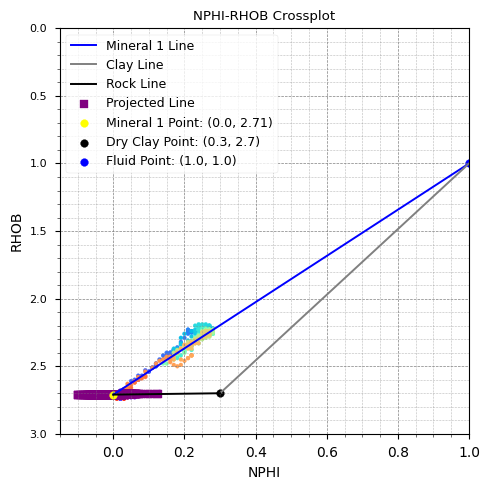

In [42]:
neutron_density_xplot(well_data['NPHI'], well_data['RHOB'], dry_min1_point=args['dry_calc_point'], **args)

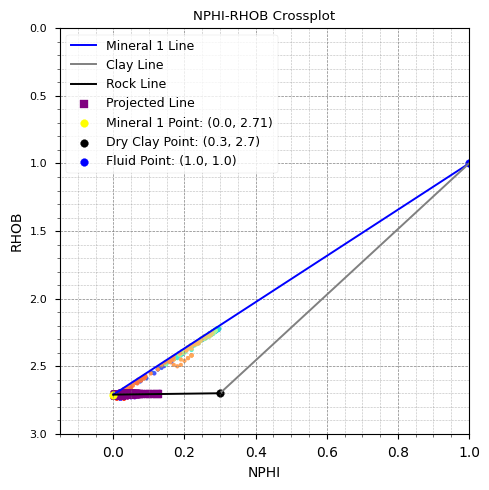

In [43]:
neutron_density_xplot(nphihc, rhobhc, dry_min1_point=args['dry_calc_point'], **args)

# quick_pp - Porosity Estimation

**Porosity** is a measure of the void spaces (pores) within a rock or sediment, expressed as a percentage of the total volume. It indicates how much of the rock is made up of these empty spaces, which can store fluids like oil, gas, or water. Porosity is crucial in the oil and gas industry because it helps determine the storage capacity of a reservoir.

Here are the main types of porosity defined in the oil and gas industry:

1. **Total Porosity**: This includes all the void spaces within the rock, regardless of whether they are interconnected or isolated. It represents the maximum potential storage capacity¹(https://www.petrosync.com/blog/what-is-porosity/).

2. **Effective Porosity**: This refers to the interconnected pore spaces that contribute to fluid flow. It is a more practical measure for reservoir engineers because it indicates the volume of voids that can actually store and transmit fluids²(https://wiki.aapg.org/Porosity).

3. **Primary Porosity**: Also known as depositional porosity, this is the original porosity of the rock formed during its deposition. It includes spaces between grains or crystals²(https://wiki.aapg.org/Porosity).

4. **Secondary Porosity**: This type of porosity develops after the rock has formed, usually due to processes like dissolution, fracturing, or recrystallization. It can significantly enhance the storage and flow capacity of a reservoir²(https://wiki.aapg.org/Porosity).

5. **Vuggy Porosity**: Characterized by large, irregular voids or cavities (vugs) formed by dissolution processes. These can greatly enhance fluid storage and flow but can also complicate reservoir characterization¹(https://www.petrosync.com/blog/what-is-porosity/).

6. **Fracture Porosity**: Created by natural fractures or cracks in the rock. While often a small percentage of the total porosity, fractures can provide significant pathways for fluid flow, especially in low-permeability rocks²(https://wiki.aapg.org/Porosity).

7. **Intergranular Porosity**: Found between the grains of sedimentary rocks like sandstones. It is typically the primary porosity in these rocks²(https://wiki.aapg.org/Porosity).

8. **Intragranular Porosity**: Occurs within the grains themselves, often in carbonate rocks. This type of porosity can be significant in certain reservoir rocks²(https://wiki.aapg.org/Porosity).

9. **Microporosity**: Consists of very small pores, often found in fine-grained rocks. While these pores can store fluids, their small size can limit fluid flow²(https://wiki.aapg.org/Porosity).

Understanding these different types of porosity helps geologists and engineers better evaluate and manage hydrocarbon reservoirs, ensuring efficient extraction and production.

Estimating porosity in carbonate formations is challenging due to complex pore structures, heterogeneity, diagenetic processes and limited core data.

These factors collectively make porosity estimation in carbonate formations a complex and nuanced task, requiring a combination of advanced techniques and a deep understanding of the geological context.

(1) What Is Porosity? Methods & Calculation Explained - PetroSync Blog. https://www.petrosync.com/blog/what-is-porosity/.

(2) Porosity - AAPG Wiki. https://wiki.aapg.org/Porosity.


In quick_pp, porosity is estimated using neutron density cross plot and using density porosity equation.
- sdf
- ssdf

With additional compressionl sonic data, secondary porosity can be estimated,
> secondary porosity = total porosity - sonic porosity


 ### PHIT MAPE: 0.20
 ### PHIT R2: 0.95


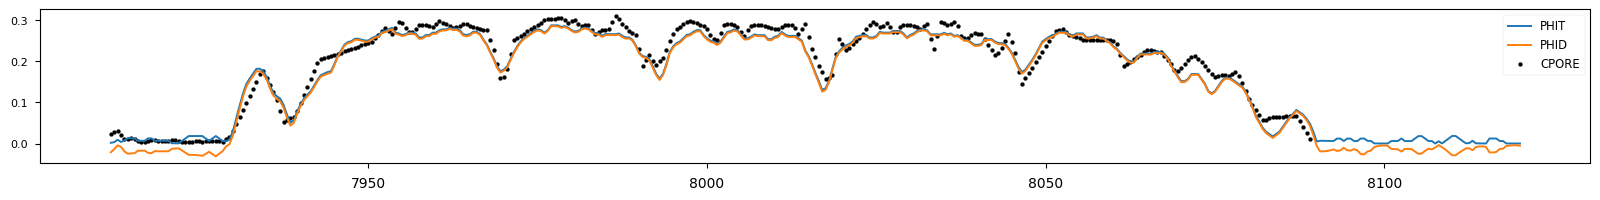

In [45]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import numpy as np

# Estimate porosity
phit = neu_den_xplot_poro(
    nphihc, rhobhc, model='carb',
    dry_min1_point=args['dry_calc_point'],
    dry_clay_point=args['dry_clay_point'],
)

# PHID needs unnormalized lithology
vclw_un, vcalc_un, vdolo_un = Carbonate(**args).estimate_lithology(
    nphihc, rhobhc, gr=well_data['GR'], vsh_gr=vsh_gr,  # pef=well_data['PEF'],
    model=model, method=method, normalize= False, carbonate_type=carbonate_type
)
rho_ma = rho_matrix(vclay=vclw_un, vcalc=vcalc_un, vdolo=vdolo_un)
phid = density_porosity(rhobhc, rho_ma)

# Fill missing values in phit with phid
phit = np.where(np.isnan(phit), phid, phit)

plt.figure(figsize=(20, 2))
plt.plot(well_data.DEPTH, phit, label='PHIT')
plt.plot(well_data.DEPTH, phid, label='PHID')
plt.scatter(well_data.DEPTH, well_data.CPORE, label='CPORE' , marker='.', color='black')

plt.legend()

score_df = well_data[['DEPTH', 'CPORE']].copy()
score_df['PHIT'] = phit
score_df.dropna(inplace=True)
print(f"\n ### PHIT MAPE: {mean_absolute_percentage_error(score_df.CPORE, score_df.PHIT):.2f}")
print(f" ### PHIT R2: {r2_score(score_df.CPORE, score_df.PHIT):.2f}")

# Plotting the result

In [46]:
well_data['NPHI_HC'] = nphihc
well_data['RHOB_HC'] = rhobhc
well_data['VCALC'] = vcalc
well_data['VDOLO'] = vdolo
well_data['VCLW'] = well_data['VSHALE'] =vclw
well_data['PHIT'] = phit
well_data['PHID'] = phid

# Plot the results
well_data.drop(columns=['VOIL', 'VGAS'], errors='ignore', inplace=True)
fig = plotly_log(well_data, depth_uom=well.depth_uom)
fig.show(config=dict(scrollZoom=True))
# fig.write_html(rf"{well_name}_log.html", config=dict(scrollZoom=True))

In [48]:
# Save the well data
project.update_data(well_data)
project.save()